In [1]:
#importing all necessary libraries
import torch as pyt
import torchvision as tv
import torcheval as te
import math
from torch import nn as nn
import torch.nn.functional as funktastic
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import ToTensor
from torch import optim
from torcheval.metrics import R2Score, MeanSquaredError


from sklearn.preprocessing import MinMaxScaler, StandardScaler, MaxAbsScaler 
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tqdm #adds progress bars
import copy #deepcopy

In [2]:
#defining method for plot display
def matplotlib_imshow(img, one_channel = False):
    if one_channel:
        img = img.mean(dim=0)
    img = img/2+0.5 #denormalize
    npimg = img.numpy()
    if one_channel:
        plt.imgshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg,(1,2,0)))

In [3]:
#confirming pytorch detects macbook m2 CPU and GPU chips
print(pyt.backends.mps.is_available())
print(pyt.backends.mps.is_built())


True
True


#Import data and separating features and dependent output variables
#trainset = features(X), trainlabels = dependent variables = (y)
trainset = pd.read_csv('../Data/weather_train.csv')
trainlabels = trainset.pop("WY.Tot.Consump.MMBtu")

In [4]:
#Import data and separate out
data = pd.read_csv('../Data/allcollprob.csv')
labels = data.pop("WY.Tot.Consump.MMBtu")

In [5]:
#Output Data and Labels to make sure they look correct
display(data)
display(labels)

,Month,Year,Tot.Consump.MMBtu,X...Per.kwh.Mo.Albany,WY.Ave.by.County,NE-US-NG.$/BTU,S-US-Elec$/KWH,W-US-Elec$/KWH,West-US-Heat$/BTU,ELEC.GEN.TOT-US-99,ELEC.GEN.NG-US-99.M,ELEC.GEN.NUC-US-99.M,ELEC.GEN.ALL-WY-99.M,ELEC.GEN.COW-WY-99.M,ELEC.GEN.PEL-WY-99.M,ELEC.GEN.NG-WY-99.M,ELEC.GEN.HYC-WY-99.M
0,1,2001,43,7.92,21.691304,1.154,0.078,0.084,1.179,332493,42389,68707,4021,3882,3,58,44
1,2,2001,41,7.92,19.443478,1.192,0.079,0.084,1.168,282940,37967,61272,3747,3627,2,50,38
2,3,2001,44,7.92,33.008696,1.196,0.080,0.084,1.129,300707,44364,62141,4093,3956,2,58,47
3,4,2001,37,7.92,42.213043,1.237,0.081,0.084,1.056,278079,45843,56003,3459,3327,2,41,68
4,5,2001,36,7.92,52.873913,1.141,0.083,0.086,1.088,300492,50934,61512,3437,3270,4,35,103
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
265,2,2023,26,15.53,19.804348,1.714,0.153,0.188,2.020,309116,123921,60807,3329,2080,5,163,45
266,3,2023,27,15.53,24.617391,1.587,0.148,0.193,1.753,329839,132153,62820,3351,2165,4,166,49
267,4,2023,22,15.53,37.182609,1.487,0.148,0.193,1.658,299673,120478,56662,2805,1661,4,180,45
268,5,2023,25,15.53,54.400000,1.402,0.147,0.195,1.697,327533,137795,61473,2705,1770,7,180,93


0      35.86500
1      32.80100
2      33.76600
3      35.60893
4      33.21135
         ...   
265    39.54405
266    36.93764
267    35.06439
268    30.14247
269    34.85928
Name: WY.Tot.Consump.MMBtu, Length: 270, dtype: float64

In [6]:
# define method to send pandas data to pytorch tensor
def to_tensor(df): return pyt.tensor(df.values.astype(np.float32))

In [7]:
X, y = data, labels
#train-test split for model evaluations
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, train_size = 0.75, shuffle = True)

#Standardize our data
scaler = StandardScaler()
scaler.fit(X_train_raw)
X_train = scaler.transform(X_train_raw)
X_test = scaler.transform(X_test_raw)

#Converting to 2D PyTorch Tensors
X_train = pyt.tensor(X_train, dtype=pyt.float32)
y_train = to_tensor(y_train).reshape(-1,1)
X_test = pyt.tensor(X_test, dtype=pyt.float32)
y_test = to_tensor(y_test).reshape(-1,1)

'''
print(X_train.size())
print(y_train.size())
print(X_test.size())
print(y_test.size())
'''

'\nprint(X_train.size())\nprint(y_train.size())\nprint(X_test.size())\nprint(y_test.size())\n'

In [8]:
#initialize and define the model

model = nn.Sequential(
    nn.Linear(17,110),
    nn.LeakyReLU(),
    nn.Linear(110,44),
    nn.LeakyReLU(),
    nn.Linear(44,16),
    nn.LeakyReLU(),
    nn.Linear(16,1)
)

In [9]:
#Set loss function and optimizer
loss_fn = nn.L1Loss() # mean squared error loss function
optimizer = optim.Adam(model.parameters(), lr=0.0005)

#Set our training parameters
n_epochs = 400 
batch_size = 10
batch_start = pyt.arange(0,len(X_train), batch_size)

#Hold the best model to use later
best_mse = np.inf
best_weights = None
history=[]


In [10]:
#start training - loop through
for epoch in range(n_epochs):
    model.train()
    with tqdm.tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
        bar.set_description(f"Epoch {epoch}")
        for start in bar:
        #takes a batch
            X_batch = X_train[start:start+batch_size]
            y_batch = y_train[start:start+batch_size]
            #forward pass
            train_pred = model(X_batch)
            loss = loss_fn(train_pred, y_batch)
            #backwards pass
            optimizer.zero_grad()
            loss.backward()
            #update weights
            optimizer.step()
            #print progress
            bar.set_postfix(mse=float(loss))
                
            
    #evaluation of accuracy at end of each epoch
    model.eval()
    test_pred = model(X_test)
    mse = loss_fn(test_pred, y_test)
    #convert loss to float val
    mse = float(mse)
    #save historic mse vals for comparison
    history.append(mse)
    if mse < best_mse:
        best_mse = mse
        best_weights = copy.deepcopy(model.state_dict())                

In [11]:
#bring back stored model and return best accuracy
model.load_state_dict(best_weights)

<All keys matched successfully>

MSE:  3.89
RMSE:  1.97


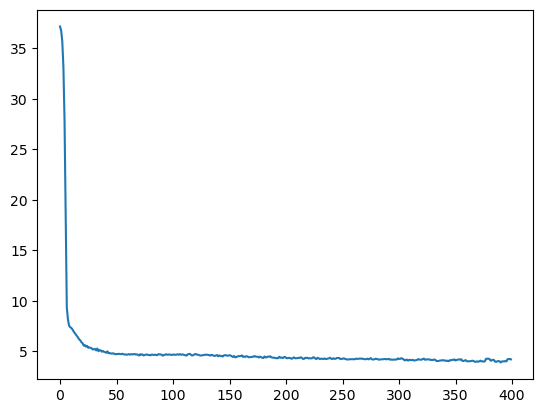

In [12]:
print("MSE: ", "%.2f" % best_mse)
print("RMSE: ", "%.2f" % np.sqrt(best_mse))
plt.plot(history)
plt.show()

train metrics:  tensor(0.7891)


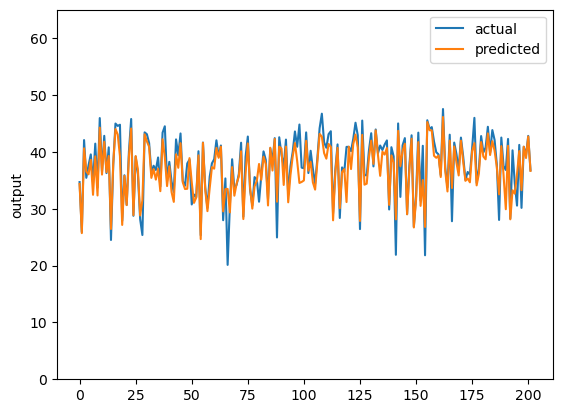

In [13]:
#reverse scaling of training data and model prediction
train_pred = model(X_train)

#print(train_pred)

traintrue = y_train.squeeze().detach().numpy()
trainpred = train_pred.squeeze().detach().numpy()

#print(trainpred)

trainmetric = R2Score(multioutput="variance_weighted")
trainmetric.update(train_pred, y_train)
print("train metrics: ", trainmetric.compute())
  


plt.figure()
plt.plot(traintrue, label="actual")
plt.plot(trainpred, label="predicted")
plt.ylabel("output")
plt.ylim(0,65)
plt.legend()
plt.show()

In [14]:
model.eval()
#test model inference with 5 samples
with pyt.no_grad():
    for i in range(5):
        X_sample = X_test_raw[i: i+1]
        X_sample = scaler.transform(X_sample)
        X_sample = pyt.tensor(X_sample, dtype=pyt.float32)
        y_sample_pred = model(X_sample)
        print(y_sample_pred.size())
        print(f"{y_sample_pred.numpy()} (expected {y_test[i].numpy()}")

torch.Size([1, 1])
[[33.0837]] (expected [31.95533]
torch.Size([1, 1])
[[32.95869]] (expected [27.4575]
torch.Size([1, 1])
[[36.376102]] (expected [31.48501]
torch.Size([1, 1])
[[38.62853]] (expected [45.03788]
torch.Size([1, 1])
[[39.30739]] (expected [40.82538]


test metrics:  tensor(0.1922)


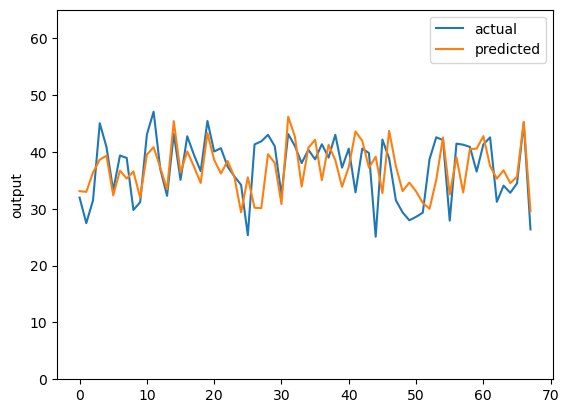

12371092102431458901


In [15]:
#reverse scaling of test data and model prediction
test_pred = model(X_test)

#print(train_pred)
testtrue = y_test.squeeze().detach().numpy()
testpred = test_pred.squeeze().detach().numpy()

#print(trainpred)

testmetric = R2Score(multioutput="variance_weighted")
testmetric.update(test_pred, y_test)
print("test metrics: ", testmetric.compute())
    


plt.figure()
plt.plot(testtrue, label="actual")
plt.plot(testpred, label="predicted")
plt.ylabel("output")
plt.ylim(0,65)
plt.legend()
plt.show()
print(pyt.seed())